In [249]:
# Standard library imports
import argparse
import re
import warnings

# Third-party libraries
import contractions
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# NLTK downloads
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

## Load data

In [293]:
def load_data(filepath):
    data = pd.read_csv(filepath, sep='\t', names=['title', 'from', 'genre', 'director', 'plot'])
    return data

In [294]:
data = load_data('train.txt')
data.head()

,title,from,genre,director,plot
0,Ela Cheppanu,Telugu,romance,Ramana,Sekhar (Tarun) is a graduate from IIM and work...
1,A Nightmare on Elm Street,American,horror,Samuel Bayer,Kris Fowles (Katie Cassidy) goes to the Spring...
2,American Gothic,American,horror,John Hough,Cynthia is traumatized by the death of her bab...
3,Gang,Bollywood,crime,Mazhar Khan,"Four friends, Gangu (Jackie Shroff), Abdul (Na..."
4,Intimate Relations,British,drama,Charles Frank,Crisis in a middle-class family when the son f...


# Clean the text

In [252]:
# Clean the text
def clean_text(text):
    # Check if the text is a non-empty string
    if not isinstance(text, str) or not text.strip():
        return ''
    
    # Skip applying contractions if the text is too long or complex
    if len(text) > 500:  # Threshold to skip contraction expansion for long texts
        return text
    
    # Try expanding contractions safely
    try:
        text = contractions.fix(text)
    except Exception as e:
        print(f"Error expanding contractions: {e}, for text: {text[:100]}...")  # Only print the first 100 characters
        return text  # Return the original text if expansion fails
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    return text

# Function to convert nltk POS tag to wordnet POS tag

In [253]:
# Function to convert nltk POS tag to wordnet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun

# Lemmatize the text

In [292]:
# Lemmatize the text removing stop words
stop_words = set(stopwords.words('english'))

def lemmatize_text(text, stopwords):
    lemmatizer = WordNetLemmatizer()
    # Clean the text
    text = clean_text(text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words and non-alphabetic tokens
    if stopwords:
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    else:
        tokens = [word for word in tokens if word.isalpha()]
    # Perform POS tagging
    tagged_tokens = nltk.pos_tag(tokens)
    # Lemmatize each token using the POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
    return ' '.join(lemmatized_tokens)


# Preprocess the data

In [295]:
# Preprocess the data without stop words
def preprocess_data(data, lemmatize, stopwords, combine_fields):
    # Extract relevant columns (plot, combine_fields, genre)
    selected_fields = ['plot'] + combine_fields
    if 'genre' in data.columns:
        selected_fields.append('genre')
    data = data[selected_fields].copy()
    
    # Handle missing values: drop rows with missing 'plot', fill missing combine_fields with ''
    data.dropna(subset=['plot'], inplace=True)  # Ensure 'plot' is not NaN
    for field in combine_fields:
        data[field] = data[field].fillna('')  # Replace NaN in combine_fields with empty strings

    # Combine plot and other specified fields into a single feature
    data['combined_text'] = data['plot']
    for field in combine_fields:
        data['combined_text'] += ' ' + data[field]

    # Apply lemmatization if specified
    if lemmatize:
        data['combined_text'] = data['combined_text'].apply(lemmatize_text, args=(stopwords,))
    else:
        # Clean the text anyway
        data['combined_text'] = data['combined_text'].apply(clean_text)

    return data

In [296]:
combine_fields = ['from', 'director', 'title']
data = preprocess_data(data, True, True, combine_fields)

# Split data into training and test sets

In [297]:
# Split data into training and test sets
def split_data(data):
    X = data['combined_text']
    y = data['genre']
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded)
    return X_train, X_test, y_train, y_test, label_encoder

In [298]:
X_train, X_test, y_train, y_test, label_encoder = split_data(data)

In [273]:
# Save label encoder
folder = 'models\\default\\'
dump(label_encoder, f'{folder}label_encoder.plk')

['models\\default\\label_encoder.plk']

# Basic Statistics

In [299]:
X_train_series = pd.Series(X_train)
y_train_series = pd.Series(y_train)

# Length analysis (counting words)
word_count= X_train_series.apply(lambda x: len(x.split()))
word_count_summary = word_count.describe()


# Print the tables
print(f"\n{'-'*60}\nWord Count Summary Statistics:\n{'-'*60}")
print(word_count_summary)


------------------------------------------------------------
Word Count Summary Statistics:
------------------------------------------------------------
count    7236.000000
mean      207.007324
std       169.177456
min         7.000000
25%        66.000000
50%       159.000000
75%       326.000000
max      1610.000000
Name: combined_text, dtype: float64


# Ploting

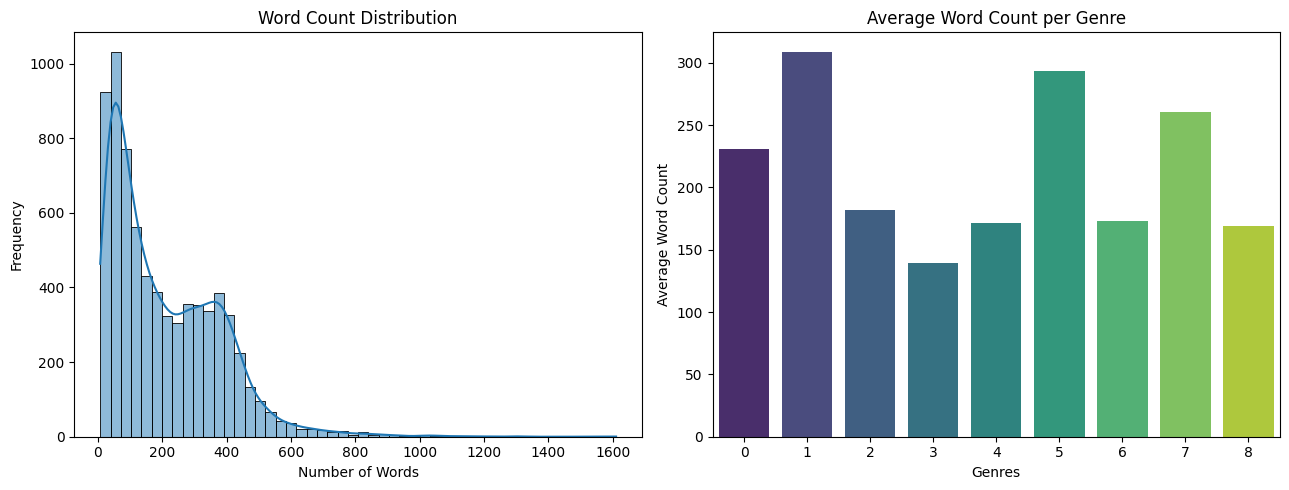

In [300]:
# Assuming word_count_remove, word_count_not_remove, genre_counts_remove, and genre_counts_not_remove are defined appropriately
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))  # Adjusted height for better layout

    # Word count distribution for word_count_remove
    sns.histplot(word_count, bins=50, ax=axes[0], kde=True)
    axes[0].set_title('Word Count Distribution')
    axes[0].set_xlabel('Number of Words')
    axes[0].set_ylabel('Frequency')

    # Distribution of word counts per genre for y_train_removed
    avg_word_count = pd.DataFrame({
        'genre': y_train,
        'word_count': word_count
    }).groupby('genre').mean()

    sns.barplot(x=avg_word_count.index, 
                y=avg_word_count['word_count'], 
                ax=axes[1], palette='viridis')
    axes[1].set_title('Average Word Count per Genre')
    axes[1].set_xlabel('Genres')
    axes[1].set_ylabel('Average Word Count')

    plt.tight_layout()
    plt.show()

# Feature extraction using count and TF-IDF vectorizers

In [301]:
max_features = 10000
ngram_range = (1, 3)

count_vectorizer = CountVectorizer(
    max_features=max_features,
    ngram_range=ngram_range, stop_words='english')

tfidf_vectorizer = TfidfVectorizer(
    max_features=max_features,
    ngram_range=ngram_range,
    sublinear_tf=True,
    norm='l2', stop_words='english')


# Feature extraction function
def extract_features(X_train, X_test, vectorizer, max_features, ngram_range):
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_test_vec


X_train_count, X_test_count = extract_features(X_train, X_test, count_vectorizer, max_features, ngram_range)
X_train_tfidf, X_test_tfidf = extract_features(X_train, X_test, tfidf_vectorizer, max_features, ngram_range)

In [274]:
# Save vectorizers
dump(count_vectorizer, f'{folder}count_vectorizer.plk')
dump(tfidf_vectorizer, f'{folder}tfidf_vectorizer.plk')

['models\\default\\tfidf_vectorizer.plk']

# Train SVM with hyperparameter tuning

In [ ]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

In [285]:
def train_svm(X_train_vec, y_train):
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear'],
        'class_weight': ['balanced', None]
    }
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train_vec, y_train)
    best_model = grid_search.best_estimator_
    
    print(f"Best SVM Parameters: {grid_search.best_params_}")
    return best_model

In [302]:
# SVM training 
svm_count = train_svm(X_train_count, y_train)
svm_tfidf = train_svm(X_train_tfidf, y_train)

Best SVM Parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
Best SVM Parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}


In [272]:
# Save SVM models
model = f'{folder}svm\\'
dump(svm_count, f'{model}svm_count.plk')
dump(svm_tfidf, f'{model}svm_tfidf.plk')

Best SVM Parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
Best SVM Parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}


# Train Multinomial NB with hyperparameter tuning

In [277]:
# Train Multinomial NB with hyperparameter tuning
def train_MultinomialNB(X_train, y_train):
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Smoothing parameter
        'fit_prior': [True, False],           # Whether to learn class prior probabilities
    }
    
    grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Best Multinomial NB Parameters: {grid_search.best_params_}")
    
    return best_model

In [303]:
# MultinomialNB training 
MultinomialNB_count = train_MultinomialNB(X_train_count, y_train)
MultinomialNB_tfidf = train_MultinomialNB(X_train_tfidf, y_train)

Best Multinomial NB Parameters: {'alpha': 2.0, 'fit_prior': True}
Best Multinomial NB Parameters: {'alpha': 0.5, 'fit_prior': False}


In [278]:
# Save MultinomialNB models
model = f'{folder}mnb\\'
dump(MultinomialNB_count, f'{model}mnb_count.plk')
dump(MultinomialNB_tfidf, f'{model}mnb_tfidf.plk')

Best Multinomial NB Parameters: {'alpha': 2.0, 'fit_prior': True}
Best Multinomial NB Parameters: {'alpha': 0.5, 'fit_prior': False}


['models\\default\\mnb\\mnb_tfidf.plk']

# Train Gaussian NB with hyperparameter tuning

In [279]:
# Train Gaussian NB with hyperparameter tuning
def train_GaussianNB(X_train, y_train):
    param_grid = {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Smoothing parameter
    }
    
    grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Best Gaussian NB Parameters: {grid_search.best_params_}")
    
    return best_model

In [304]:
# Dense format conversion
X_train_count_dense = X_train_count.toarray()
X_train_tfidf_dense = X_train_tfidf.toarray()

# GaussianNB training 
GaussianNB_count = train_GaussianNB(X_train_count_dense, y_train)
GaussianNB_tfidf = train_GaussianNB(X_train_tfidf_dense, y_train)

Best Gaussian NB Parameters: {'var_smoothing': 1e-05}
Best Gaussian NB Parameters: {'var_smoothing': 1e-05}


In [280]:
# Save GaussianNB models
model = f'{folder}gnb\\'
dump(GaussianNB_count, f'{model}gnb_count.plk')
dump(GaussianNB_tfidf, f'{model}gnb_tfidf.plk')

Best Gaussian NB Parameters: {'var_smoothing': 1e-05}
Best Gaussian NB Parameters: {'var_smoothing': 1e-05}


['models\\default\\gnb\\gnb_tfidf.plk']

# Evaluate the model

In [289]:
def evaluate_model(model, X_test_tfidf, y_test):
    predictions = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    return accuracy, cm, report


In [305]:
# Dense format conversion
X_test_count_dense = X_test_count.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

In [306]:
accuracy_svm_count = evaluate_model(svm_count, X_test_count, y_test)[0]
print(f"Accuracy SVM_count: {accuracy_svm_count * 100:.2f}%")
accuracy_svm_tfidf = evaluate_model(svm_tfidf, X_test_tfidf, y_test)[0]
print(f"Accuracy SVM_tfidf: {accuracy_svm_tfidf * 100:.2f}%")

accuracy_mnb_count = evaluate_model(MultinomialNB_count, X_test_count, y_test)[0]
print(f"\nAccuracy MultinomialNB_count: {accuracy_mnb_count * 100:.2f}%")
accuracy_mnb_tfidf = evaluate_model(MultinomialNB_tfidf, X_test_tfidf, y_test)[0]
print(f"Accuracy MultinomialNB_tfidf: {accuracy_mnb_tfidf * 100:.2f}%")

accuracy_gnb_count = evaluate_model(GaussianNB_count, X_test_count_dense, y_test)[0]
print(f"\nAccuracy GaussianNB_count: {accuracy_gnb_count * 100:.2f}%")
accuracy_gnb_tfidf = evaluate_model(GaussianNB_tfidf, X_test_tfidf_dense, y_test)[0]
print(f"Accuracy GaussianNB_tfidf: {accuracy_gnb_tfidf * 100:.2f}%")

Accuracy SVM_count: 59.75%
Accuracy SVM_tfidf: 68.82%

Accuracy MultinomialNB_count: 63.73%
Accuracy MultinomialNB_tfidf: 65.47%

Accuracy GaussianNB_count: 42.48%
Accuracy GaussianNB_tfidf: 43.23%


# Load the model and vectorizer

In [307]:
def load_model(model_path, vectorizer_path, label_encoder_path):
    model = load(model_path)
    vectorizer = load(vectorizer_path)
    label_encoder = load(label_encoder_path)
    return model, vectorizer, label_encoder

In [315]:
best_model_path = f'{folder}svm\\svm_tfidf.plk'
vectorizer_path = f'{folder}tfidf_vectorizer.plk'
label_encoder_path = f'{folder}label_encoder.plk'

model, vectorizer, label_encoder = load_model (best_model_path, vectorizer_path, label_encoder_path)
X_test_vec = vectorizer.transform(X_test)
svm_accuracy, svm_cm, svm_report = evaluate_model(model, X_test_vec, y_test)
print(f'best model accuracy : {svm_accuracy*100:.2f}%')

best model accuracy : 70.19%


# Predict the genre for new movie plots

In [316]:
def predict_genre(model, vectorizer, label_encoder, input_file, output_file, lemmatize, stopwords, combine_fields):
    data = pd.read_csv(input_file, sep='\t', names=['title', 'from', 'director', 'plot'])
    data = preprocess_data(data, lemmatize, stopwords, combine_fields)
    plots = data['combined_text']
    plot_vectors = vectorizer.transform(plots)
    predicted_genres_encoded = model.predict(plot_vectors)
    predicted_genres = label_encoder.inverse_transform(predicted_genres_encoded)

    # Save the results to a file
    data['genre'] = predicted_genres
    data[['title', 'from', 'director', 'plot', 'genre']].to_csv(output_file, sep='\t', index=False)
